# Efficient Fine-Tuning for Mistral-7b on a Single GPU using Ludwig

Example: to train a foundation Mistral-7b for code generation

This notebook is adapted from [Ludwig](https://colab.research.google.com/drive/1r4oSEwRJpYKBPM0M0RSh0pBEYK_gBKbe).

## Fine-Tuning

There are three different fine-tuning approaches in Ludwig:

- **Full Fine-Tuning**
- **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**
- **Quantization-Based Fine-Tuning (QLoRA)**

In this notebook, we shall fine-tune using QLoRA given a single T4 GPU with 16GiB of GPU VRAM on Colab.

## Setup

In [1]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig --quiet
!pip install ludwig[llm] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  

In [7]:
!pip install --upgrade git+https://github.com/huggingface/peft.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
    if torch.cuda.is_available():
        model = None
        torch.cuda.empty_cache()

In [2]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel

# HuggingFace Token
os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


## Import The Code Generation Dataset

We shall load dataset `code_alpaca_20k`.

In [3]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# Here, we will use 1000 rows of this dataset.
df = df.head(n=1000)

### Understanding The Code Alpaca Dataset




In [5]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


This dataset is meant to train a large language model to following instructions to produce code from natural language. Each row in the dataset consists of an:
- `instruction` that describes a task
- `input` when additional context is required for the instruction, and
- the expected `output`.

There are two types of instructions:

#### **Type 1: Self-Sufficient**
Instructions that are self-sufficient and require no additional context.
```
Instruction: "Create an array of length 5 which contains all even numbers between 1 and 10."
Input: None (instruction is self-sufficient)
Output: "arr = [2, 4, 6, 8, 10]"
```

These examples are useful for training models to understand and follow instructions independently. They can be applied in various scenarios, including:

- **Coding Tasks**: Teaching a model to generate code based on a clear instruction. For instance, generating a function to sort an array in a specific way.
- **Mathematical Calculations**: Instructing a model to perform calculations or equations, such as finding the area of a shape given its dimensions.
- **Data Manipulation**: Showing how to process data, like filtering, transforming, or aggregating data based on given criteria.
- **Writing Instructions**: Training models to generate instructional content, like recipes, guides, or tutorials.

#### **Type 2: Need Context**
The instruction needs additional context provided in the `input` to complete the task.
```
Instruction: "Write a replace method for a string class which replaces the given string with a given set of characters."
Input: "string = 'Hello World!' replace_with = 'Greetings!'"
Output:
def replace(string, replace_with):
    new_string = ""
    for char in string:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string
```

These examples are useful for training models to understand both the instruction and relevant context provided by the input. They find application in scenarios such as:

- **Customized Code Generation**: Teaching a model to generate code that depends on specific inputs. For instance, creating a function to calculate a mathematical result given input parameters.
- **Conditional Responses**: Guiding models to produce outputs that change based on different input conditions (think of a instruction that has different criteria for different letter grades, and then a conditional input like score = 85/100)
- **Dynamic Content Creation**: Training models to generate content based on variable input, such as dynamic forms, letters, or responses to user queries.
- **Configurable Processes**: Demonstrating how to perform tasks with customizable settings, like configuring a software component using provided parameters.


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset with 20,000 rows).

In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_contex = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_contex/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 100
% of examples that are self-sufficient: 49.0
% of examples that are need additional context: 51.0


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



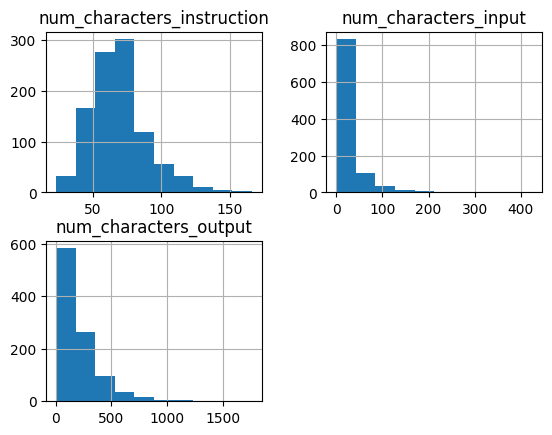

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

## Fine-Tuning

We shall fine-tune using QLoRA given a single T4 GPU with 16GiB of GPU VRAM on Colab. LoRA based fine-tuning or full fine-tuning typically requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeed.

To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

Note, there are a few additional preprocessing parameters we should set to ensure that training runs smoothly:

```yaml
preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.9
    - 0.05
    - 0.05
```

Some of the examples in the dataset have long sequences, so we set a `global_max_sequence_length` of 512 to ensure that we do not OOM.

We also use 100% of data for training as the evaluation phase takes extra time and we will predict on new examples right afterwards.

In [4]:
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
# We use a resharded model here since the base model does not have safetensors support.
base_model: alexsherstinsky/Mistral-7B-v0.1-sharded

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 0.9
    - 0.05
    - 0.05

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_1                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 900 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 4500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|██████████| 900/900 [10:57<00:00,  1.42it/s, loss=0.0428]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 900, epoch: 0


Evaluation test : 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]

INFO:ludwig.trainers.trainer:Evaluation took 41.5310s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.2215 │       0.2254 │     0.2077 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.2920 │       1.1644 │     1.1407 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.6108 │       0.5257 │     0.6521 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14500.0029 │   14574.0879 │ 15070.6562 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31386.5449 │   31632.2598 │ 31646.5312 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.41


Training: 100%|██████████| 900/900 [11:39<00:00,  1.29it/s, loss=0.0428]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 900                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 1                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 0.5257427096366882 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 0.6520677208900452 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [5]:
!ls /content/results/api_experiment_run/model

training_set_metadata.json


## Inference

Test the fine-tuned model

In [6]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples, generation_config={'temperature': 0.1, 'max_new_tokens': 128})[0]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response: let arr = [2, 4, 6, 8, 10];
INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an

Prediction: 100%|██████████| 1/1 [00:23<00:00, 23.05s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [8]:
for input_with_prediction in zip(test_examples["instruction"], test_examples["input"], predictions["output_response"]):
    print(f"Instruction: {input_with_prediction[0]}")
    print(f"Input: {input_with_prediction[1]}")
    print(f"Generated Output:\n```\n{input_with_prediction[2][0]}\n```\n\n")

Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output:
```
let arr = [2, 4, 6, 8, 10];
```


Instruction: Create an array of length 15 containing numbers divisible by 3 up to 45.
Input: 
Generated Output:
```
let arr = [];
for (let i = 0; i < 15; i++) {
    if (i % 3 === 0) {
        arr.push(i);
    }
}
console.log(arr);
```


Instruction: Create a nested loop to print every combination of numbers between 0-9
Input: 
Generated Output:
```
for i in range(10):
    for j in range(10):
        print(i, j)
```


Instruction: Generate a function that computes the sum of the numbers in a given list
Input: 
Generated Output:
```
def sum_list(nums):
    return sum(nums)
```


Instruction: Create a class to store student names, ages and grades.
Input: 
Generated Output:
```
class student:
    def __init__(self, name, age, grade):
        self.name = name
        self.age = age
        self.grade = grade
```


Instruction: Print out t

## Notes

**Explore LoRA or Full Fine-Tuning with Ludwig**

- For LoRA based fine-tuning, just remove the `quantization` section in the config above.
- For full fine-tuning, remove both the `quantization` and `adapter` sections above.

Additionally, you will need to configure [DeepSpeed](https://www.deepspeed.ai/) for distributed model and data parallel training. This can be configured very easily with Ludwig, full docs [here](https://ludwig.ai/latest/configuration/backend/#deepspeed). Here's an example backend section of the Ludwig config:

```yaml
backend:
  type: ray
  trainer:
    use_gpu: true
    strategy:
      type: deepspeed
      zero_optimization:
        stage: 3
        offload_optimizer:
          device: cpu
          pin_memory: true
      bf16:
        enabled: true
```